In [54]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy
from icecream import ic
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math


# Excercise 4

Write a discrete event simulation program for a blocking system, i.e. a system with m service units and no waiting room. The offered traffic A is the product of the mean arrival rate and the mean service time.

#### 1. The arrival process is modelled as a Poisson process. Report the fraction of blocked customers, and a confidence interval for this fraction. Choose the service time distribution as exponential. Parameters: m = 10, mean service time = 8 time units, mean time between customers = 1 time unit (corresponding to an offered traffic of 8 Erlang), 10 x 10.000 customers. This system is sufficiently simple such that the analytical solution is known. See the last slide for the solution. Verify your simulation program using this knowledge.

First we initialize the parameters

In [2]:
m = 10  # Number of service units
mean_service_time = 8  # Mean service time in time units
mean_interarrival_time = 1  # Mean time between customer arrivals in time units
num_customers = 10_000  # Number of customers to simulate
num_simulations = 10  # Number of simulation runs

We make a function that can simulate a given number of simulations 

In [110]:
# Exponential
def arrival_time_distribution(mean_interarrival_time = mean_interarrival_time):
    time = np.random.exponential(mean_interarrival_time)
    return time

def service_time_distribution(mean_service_time = mean_service_time):
    time = np.random.exponential(mean_service_time)
    return time

# Main simulation
def simulate_service_system(m=10, mean_service_time=8, mean_interarrival_time=1, num_customers=10_000, num_simulations=10):
    blocked_list = []

    for _ in range(num_simulations):
        service_list = np.zeros(m)
        blocked_count = 0
        minutes = 0

        for _ in range(num_customers):
            time = arrival_time_distribution()
            minutes += time

            service_list[service_list > 0] -= time  # Subtract time from all customers being serviced
            service_list[service_list < 0] = 0  # If service time is below zero, reset it to zero to mark the desk as empty.

            # If people arrived in the given minute, check for empty service desks
            empty_service_desk_indices = np.where(service_list == 0)[0]

            if empty_service_desk_indices.size > 0:
                empty_service_desk_index = empty_service_desk_indices[0]
                service_time = service_time_distribution(mean_service_time)
                service_list[empty_service_desk_index] = service_time
            else:
                blocked_count += 1

        blocked_list.append(blocked_count)
    
    return blocked_list


We run the code

In [85]:
results = simulate_service_system(m=10, 
                                  mean_service_time=8, 
                                  mean_interarrival_time=1, 
                                  num_customers=10_000, 
                                  num_simulations=1000)

We visualize the distributions

##### We calculate the confidence interval 

In [101]:
def plot_histogram_blocked():
    # We calculate confidence interval
    # Calculate mean and standard deviation
    mean_blocked = np.mean(blocked_counts)
    std_blocked = np.std(blocked_counts)

    # Calculate the 95% confidence interval
    confidence_interval = stats.t.interval(0.95, len(blocked_counts)-1, loc=mean_blocked, scale=stats.sem(blocked_counts))

    # Plot the results
    sns.histplot(blocked_counts, kde=True)
    plt.axvline(mean_blocked, color='r', linestyle='--')
    plt.axvline(confidence_interval[0], color='g', linestyle='--')
    plt.axvline(confidence_interval[1], color='g', linestyle='--')
    plt.xlabel('Total Blocked Customers')
    plt.ylabel('Frequency')
    plt.title('Distribution of Total Blocked Customers with 95% Confidence Interval')
    plt.show()

    # Print the confidence interval
    print(f"95% Confidence Interval: {confidence_interval}")

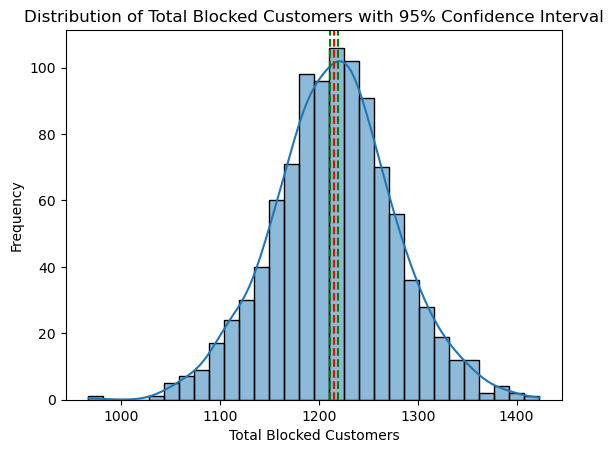

95% Confidence Interval: (1211.4543166864287, 1219.1096833135712)


In [48]:
plot_histogram_blocked()

We can verify it the calculated 95% Confidence Interval: (1211.4543166864287, 1219.1096833135712) is corresponding to the theoretical confidence interval for this distribution

In [49]:
def B(A, m):
    numerator = (A ** m) / math.factorial(m)
    denominator = sum((A ** i) / math.factorial(i) for i in range(m + 1))
    return numerator / denominator

In [50]:
m = 10  # Number of service units
A = mean_service_time * mean_interarrival_time # A

In [51]:
print(B(A,m))

0.12166106425295149


They seem to corresponds nicely

Lets visualize the distribution of customers being served

In [43]:
customers_being_served_combiend = []

for i in range(10):
    customers_being_served_combiend += results[i]["customers_being_served"]

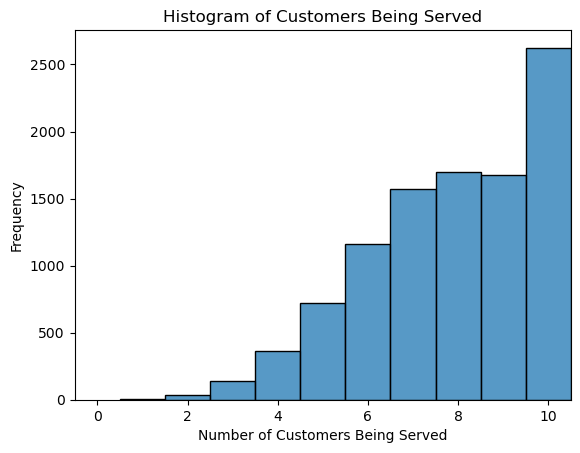

In [44]:
# Create the histogram
sns.histplot(customers_being_served, bins=np.arange(12) - 0.5, discrete=True)

# Set the x-axis limits to show all integer values from 0 to 10
plt.xlim(-0.5, 10.5)

# Add labels and title for clarity
plt.xlabel('Number of Customers Being Served')
plt.ylabel('Frequency')
plt.title('Histogram of Customers Being Served')

# Show the plot
plt.show()

#### 2. The arrival process is modelled as a renewal process using the same parameters as in Part 1 when possible. Report the fraction of blocked customers, and a confidence interval for this fraction for at least the following two cases

##### (a) Experiment with Erlang distributed inter arrival times The Erlang distribution should have a mean of 1

In [91]:
#Erlang
def arrival_time_distribution(mean_interarrival_time = mean_interarrival_time ):
    time = np.random.gamma(mean_interarrival_time)
    return time

results = simulate_service_system(m=10, 
                                  mean_service_time=8, 
                                  mean_interarrival_time=1, 
                                  num_customers=10_000, 
                                  num_simulations=1000)

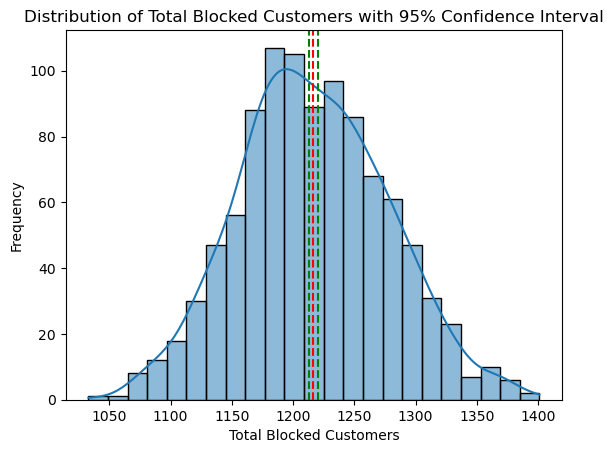

95% Confidence Interval: (1212.6072239571838, 1220.1567760428163)


In [92]:
plot_histogram_blocked()

##### (b) hyper exponential inter arrival times. The parameters for the hyper exponential distribution should be p1 = 0.8,λ1 = 0.8333,p2 = 0.2,λ2 = 5.0.

In [93]:
# Hyperexponential
def arrival_time_distribution(p = [0.8, 0.2], lam = [0.8333, 5.0]):

    # Generate exponential outcomes for each lambda value
    outcomes = [np.random.exponential(scale=1/l) for l in lam]
    
    # Select one outcome based on the given probabilities
    time = np.random.choice(outcomes, p=p)
    return time

results = simulate_service_system(m=10, 
                                  mean_service_time=8, 
                                  mean_interarrival_time=1, 
                                  num_customers=10_000, 
                                  num_simulations=1000)

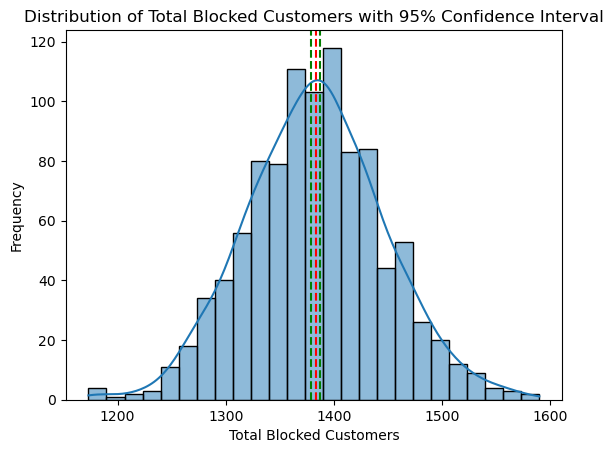

95% Confidence Interval: (1379.0322692000932, 1386.9537307999067)


In [94]:
plot_histogram_blocked()

#### 3. The arrival process is again a Poisson process like in Part 1. Experiment with different service time distributions with the same mean service time and m as in Part 1 and Part 2.

##### (a) Constant service time

In [112]:
# Arrival time distribution
def arrival_time_distribution(mean_interarrival_time = mean_interarrival_time):
    time = np.random.exponential(mean_interarrival_time)
    return time

# Service time distribution

def service_time_distribution(mean_service_time = mean_service_time):
    time = 8
    return time

results = simulate_service_system(m=10, 
                                  mean_service_time=8, 
                                  mean_interarrival_time=1, 
                                  num_customers=10_000, 
                                  num_simulations=200)

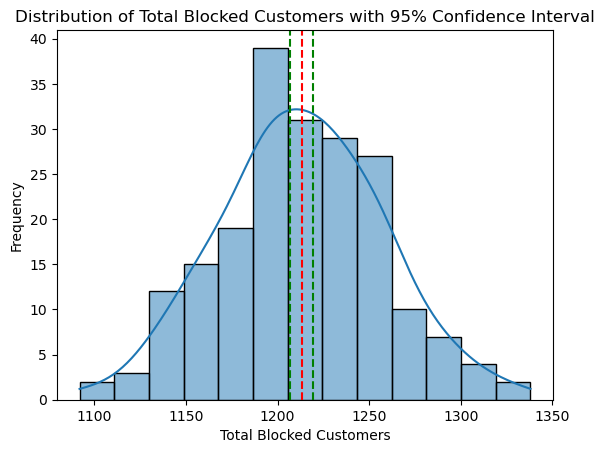

95% Confidence Interval: (1206.942976114847, 1219.347023885153)


In [113]:
plot_histogram_blocked()

##### (b) Pareto distributed service times with at least k = 1.05 and k =2.05.

k = 1.05

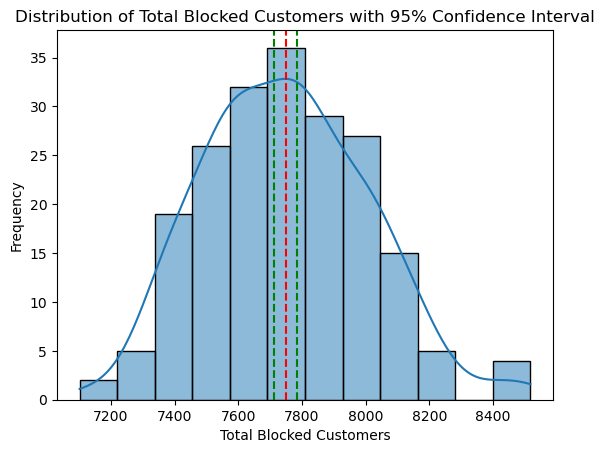

95% Confidence Interval: (7712.4460978546185, 7784.3039021453815)


In [117]:
# Arrival time distribution
def arrival_time_distribution(mean_interarrival_time = mean_interarrival_time):
    time = np.random.exponential(mean_interarrival_time)
    return time

# Service time distribution Pareto 

def service_time_distribution(mean_service_time = mean_service_time, k = 1.05):
    U = np.random.uniform()
    time = mean_service_time * ((U ** ( -(1 / k))) - 1)
    return time

results = simulate_service_system(m=10, 
                                  mean_service_time=8, 
                                  mean_interarrival_time=1, 
                                  num_customers=10_000, 
                                  num_simulations=200)
plot_histogram_blocked()

k = 2.05

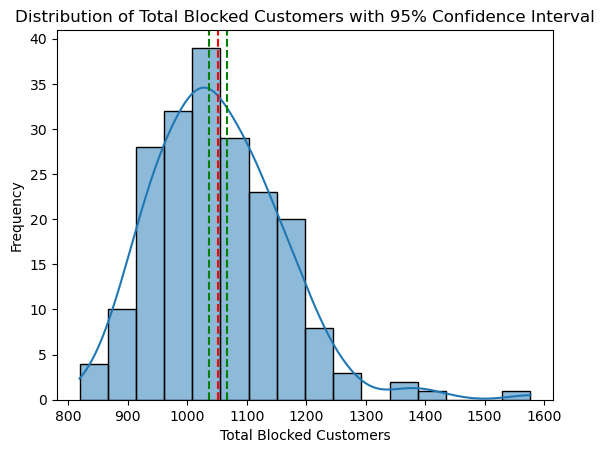

95% Confidence Interval: (1036.5264026727357, 1067.0035973272645)


In [119]:
# Arrival time distribution
def arrival_time_distribution(mean_interarrival_time = mean_interarrival_time):
    time = np.random.exponential(mean_interarrival_time)
    return time

# Service time distribution Pareto 

def service_time_distribution(beta = mean_service_time, k = 2.05):
    U = np.random.uniform()
    time = beta* ((U ** ( -(1 / k))) - 1)
    return time

results = simulate_service_system(m=10, 
                                  mean_service_time=8, 
                                  mean_interarrival_time=1, 
                                  num_customers=10_000, 
                                  num_simulations=200)
plot_histogram_blocked()

#### (c) choose one or two other distributions

We can try with a rayleigh distribution

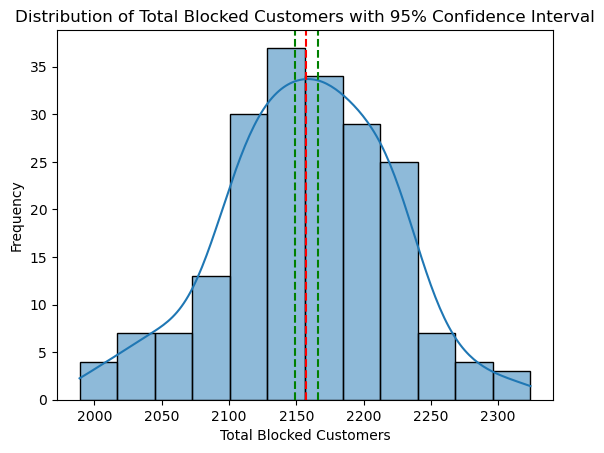

95% Confidence Interval: (2148.709304595462, 2165.970695404538)


In [121]:
# Arrival time distribution
def arrival_time_distribution(mean_interarrival_time = mean_interarrival_time):
    time = np.random.exponential(mean_interarrival_time)
    return time

# Service time distribution Pareto 

def service_time_distribution(mean = mean_service_time):
    time = np.random.rayleigh(scale = mean)
    return time

results = simulate_service_system(m=10, 
                                  mean_service_time=8, 
                                  mean_interarrival_time=1, 
                                  num_customers=10_000, 
                                  num_simulations=200)
plot_histogram_blocked()

We try a gaussian normal distribution for the service time

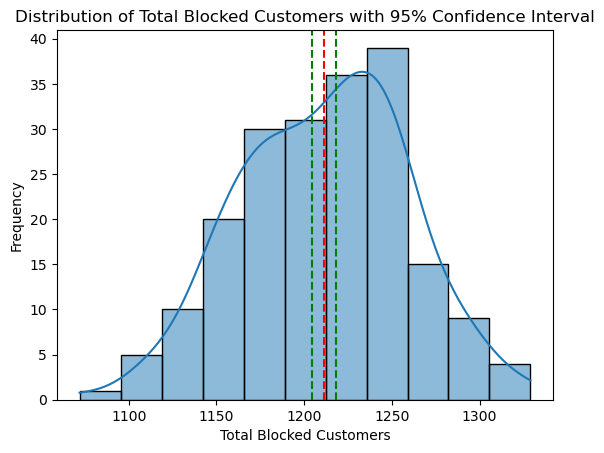

95% Confidence Interval: (1204.748030508779, 1217.9319694912208)


In [122]:
# Arrival time distribution
def arrival_time_distribution(mean_interarrival_time = mean_interarrival_time):
    time = np.random.exponential(mean_interarrival_time)
    return time

# Service time distribution Pareto 

def service_time_distribution(mean = mean_service_time):
    time = np.random.normal(mean)
    return time

results = simulate_service_system(m=10, 
                                  mean_service_time=8, 
                                  mean_interarrival_time=1, 
                                  num_customers=10_000, 
                                  num_simulations=200)
plot_histogram_blocked()

### 4. Compare confidence intervals for Parts 1, 2, and 3 then interpret and explain differences if any.


By trying different distribution functions for the service and arrival time we notice that they can have a big impact on the confidence intervals of the amount of customers being blocked. 

This is reasonable, as the distributions will affect the time each customer spends at the service desk, as well as the time between each arrival. 

An example of this is that if the arrival distribution allows that many customers arrive during a short period of time, and the service distribution give a burst of high service times, that would result in a high frequency of blocked people. 